In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

In [2]:
df = pd.read_csv("./data.csv")
df.head()

,tweet_created_at,city of the user,country of the user,state of the user,tweet_id,retweet_count,text,text_keywords,user_favourites_count,user_friends_count,user_statuses_count,user_verified
0,Sun Apr 06 03:11:03 +0000 2014,Lincoln Park,United States,Michigan,4.526450e+17,0,@xoBrittanyGlenn @Anggg_xoxo Railee got the fl...,got;shot;still;flu,937,412,7518,False
1,Sun Apr 06 04:06:01 +0000 2014,Montgomery,United States,alabama,4.526580e+17,0,Need a flu shot cuz my watch sick,need;shot;sick;flu,1896,784,43591,False
2,Sun Apr 06 06:20:41 +0000 2014,Visalia,United States,California,4.526920e+17,0,@andylassner: I'll grab something off a room s...,care;shot;something;flu,178,93,224,False
3,Sun Apr 06 17:01:32 +0000 2014,Boston,United States,Massachusetts,4.528540e+17,0,A cold in April.... even after getting a flu s...,even;flu;shot;getting;cold,8,1993,740,False
4,Sun Apr 06 17:07:17 +0000 2014,Albany,United States,New York,4.528550e+17,0,last time all 302 followers I have are going t...,going;get;flu;last;time;shot,702,666,2036,False


In [3]:
df.describe()

,tweet_id,retweet_count,user_favourites_count,user_friends_count,user_statuses_count
count,2.620600e+04,26206.000000,26206.000000,26206.000000,26206.000000
mean,5.012003e+17,0.004045,2819.068114,762.789857,15744.136534
std,4.820605e+16,0.081385,9482.276402,4140.818058,26890.928007
min,4.181700e+17,0.000000,0.000000,0.000000,0.000000
25%,4.409188e+17,0.000000,149.000000,197.250000,2522.000000
50%,5.211580e+17,0.000000,732.000000,361.000000,7067.500000
75%,5.309675e+17,0.000000,2574.750000,691.750000,17625.500000
max,5.940910e+17,7.000000,681620.000000,360790.000000,609809.000000


In [4]:
df.isna().sum()

tweet_created_at            0
city of the user            0
country of the user         0
state of the user        2121
tweet_id                    0
retweet_count               0
text                        0
text_keywords               0
user_favourites_count       0
user_friends_count          0
user_statuses_count         0
user_verified               0
dtype: int64

# Apriori

We will use the framework given by Professor Kai Shu's notes as a guideline for implementing the Apriori algorithm. We build a general algorithm that takes in a pandas dataframe and operates on one column.

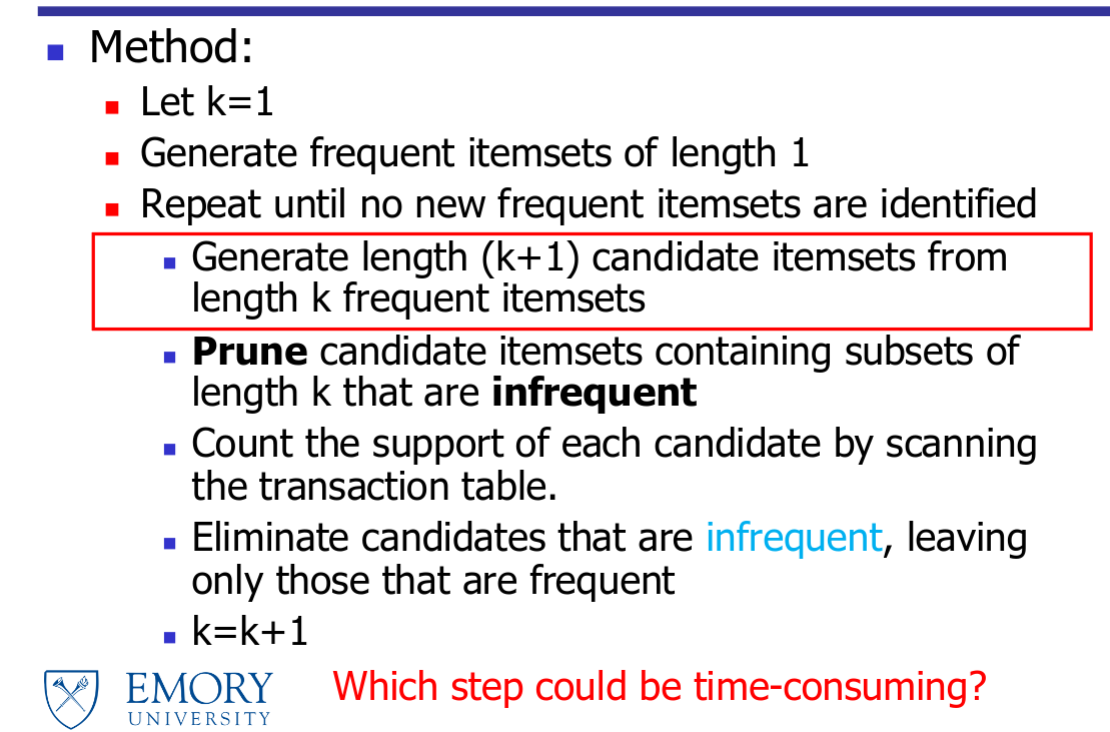


# Experimentation

[Look here for more resources (in depth)](https://www-users.cse.umn.edu/~kumar001/dmbook/ch5_association_analysis.pdf)

In [5]:
def parse_keywords(keywords: str):
    return set(keywords.split(";"))

In [8]:
test_kws = df.iloc[0]["text_keywords"]
print(parse_keywords(test_kws))
print(type(parse_keywords(test_kws)))
# test_kws.split(";")

{'shot', 'got', 'flu', 'still'}
<class 'set'>


In [38]:
def generate_1_itemsets(df: pd.DataFrame, target_col: str, min_support: int) -> set:
    counts = {}

    for kw_line in df[target_col]:
        kws = kw_line.split(";")

        for kw in kws:
            if kw in counts:
                counts[kw] += 1
            else:
                counts[kw] = 1

    ans = set()

    for k, v in counts.items():
        if v >= min_support:
            ans.add((k, v))

    return ans

In [33]:
one_itemsets = generate_1_itemsets(df, "text_keywords", 500)
print(one_itemsets)

{('going', 770), ('free', 1013), ('mom', 552), ('sick', 1842), ('got', 7396), ('work', 968), ('get', 7647), ('every', 569), ('one', 915), ('vaccine', 519), ('getting', 3087), ('right', 541), ('need', 814), ('flu', 26186), ('feel', 1018), ('first', 633), ('shots', 2573), ('sore', 675), ('never', 917), ('still', 990), ('last', 664), ('arm', 2023), ('year', 1534), ('lol', 503), ('shot', 23167), ('even', 611), ('better', 593), ('like', 1940), ('really', 580), ('gotten', 695), ('hurts', 530), ('day', 759), ('know', 523), ('think', 649), ('amp', 959), ('time', 1404), ('today', 2729)}


# Apriori Algorithm Implementation

We choose to use the F_k-1 x F_k scheme for candidate generation. The general process is as follows:

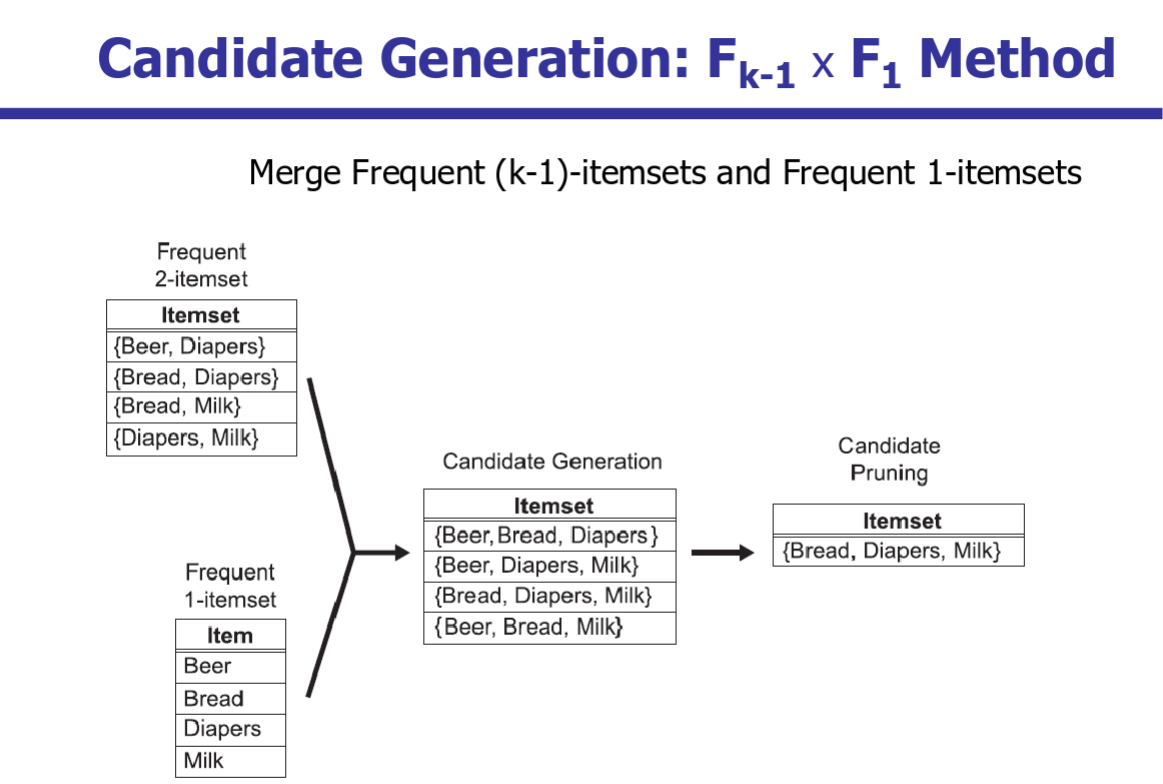

Steps:
1. Get $F_{k-1}$ and {F_k}
2. Merge them for all possible set pairwise set unions($C = \{a \cup b | a \in F_{k-1} , b \in F_k\}$)
3. Prune

In [11]:
def parse_entry(entry) -> list:
    return entry.split(";")

In [12]:
def apriori(df, column_name, min_support):
    # Drop entries with empty item sets
    entries = df[column_name].dropna()

    # Immutable sets for hashing (Optimization)
    parsed_entries = [frozenset(parse_entry(entry)) for entry in entries]

    # Get item counts
    counts = {}
    for entry in parsed_entries:
        for item in entry:
            counts[item] = counts.get(item, 0) + 1
    
    # F_1
    f_1 = {frozenset([item]): count for item, count in counts.items() if count >= min_support}
    
    f_k_minus_1 = f_1
    frequent_itemsets = [items_count_pair for items_count_pair in f_1.items()]
    k = 2
    
    while f_k_minus_1:
        candidates = set()
        f_k_minus_1_keys = list(f_k_minus_1.keys())
        
        # Candidate generation using F_k-1 x F_1
        for f_set in f_k_minus_1_keys:
            for item in f_1.keys():
                candidate = f_set | item
                if len(candidate) == k:
                    candidates.add(candidate)
        
        # Count candidates
        candidate_counts = {c: 0 for c in candidates}
        for entry in parsed_entries:
            for candidate in candidates:
                if candidate.issubset(entry):
                    candidate_counts[candidate] += 1
        
        # Prune
        f_k = {itemset: count for itemset, count in candidate_counts.items() if count >= min_support}
        
        if not f_k:
            break
        
        frequent_itemsets.extend([items_count_pair for items_count_pair in f_k.items()])
        f_k_minus_1 = f_k
        k += 1
    
    return frequent_itemsets

# Testing

In [13]:
min_support = 500

In [15]:
ans = apriori(df=df, column_name="text_keywords", min_support=min_support)

In [16]:
ans

[(frozenset({'shot'}), 23167),
 (frozenset({'got'}), 7396),
 (frozenset({'flu'}), 26186),
 (frozenset({'still'}), 990),
 (frozenset({'sick'}), 1842),
 (frozenset({'need'}), 814),
 (frozenset({'getting'}), 3087),
 (frozenset({'even'}), 611),
 (frozenset({'get'}), 7647),
 (frozenset({'going'}), 770),
 (frozenset({'last'}), 664),
 (frozenset({'time'}), 1404),
 (frozenset({'every'}), 569),
 (frozenset({'amp'}), 959),
 (frozenset({'year'}), 1534),
 (frozenset({'first'}), 633),
 (frozenset({'think'}), 649),
 (frozenset({'today'}), 2729),
 (frozenset({'know'}), 523),
 (frozenset({'gotten'}), 695),
 (frozenset({'right'}), 541),
 (frozenset({'like'}), 1940),
 (frozenset({'arm'}), 2023),
 (frozenset({'hurts'}), 530),
 (frozenset({'shots'}), 2573),
 (frozenset({'mom'}), 552),
 (frozenset({'never'}), 917),
 (frozenset({'vaccine'}), 519),
 (frozenset({'work'}), 968),
 (frozenset({'better'}), 593),
 (frozenset({'really'}), 580),
 (frozenset({'one'}), 915),
 (frozenset({'lol'}), 503),
 (frozenset({'f

In [25]:
for items_count_pair in ans:
    print(" ".join(list(items_count_pair[0])) + f" ({items_count_pair[1]})")

shot (23167)
got (7396)
flu (26186)
still (990)
sick (1842)
need (814)
getting (3087)
even (611)
get (7647)
going (770)
last (664)
time (1404)
every (569)
amp (959)
year (1534)
first (633)
think (649)
today (2729)
know (523)
gotten (695)
right (541)
like (1940)
arm (2023)
hurts (530)
shots (2573)
mom (552)
never (917)
vaccine (519)
work (968)
better (593)
really (580)
one (915)
lol (503)
feel (1018)
sore (675)
free (1013)
day (759)
first shot (592)
year flu (1530)
get shot (6959)
gotten shot (665)
work flu (968)
vaccine flu (518)
shots flu (2573)
get today (656)
shot getting (2764)
last shot (599)
shot work (799)
first flu (632)
time flu (1403)
hurts flu (530)
shot think (564)
need flu (814)
amp flu (959)
shots get (649)
shot still (886)
free shot (624)
sick shot (1685)
really shot (521)
lol flu (503)
still flu (989)
better flu (593)
amp shot (773)
sick got (680)
year shot (1402)
shot got (6963)
shot time (1253)
like shot (1692)
today flu (2726)
shot day (667)
going shot (688)
day flu 